<a href="https://colab.research.google.com/github/hrehmanbee24seecs/Traffic-sign-recognition-model-/blob/main/Traffic_sign_recognition_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition

## File handling

In [6]:
# ===============================
# Robust ZIP extraction + dataset discovery
# ===============================


from google.colab import drive
import os, subprocess

drive.mount('/content/drive', force_remount=False)

ZIP_PATH = "/content/drive/MyDrive/archive (11).zip"
def run(cmd):
    return subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# 1. Ensure 7z exists
run("apt-get update -qq")
run("apt-get install -y p7zip-full -qq")

# 2. Extract ZIP into /content (fast)
print("Extracting ZIP...")
res = run(f'7z x "{ZIP_PATH}" -o"/content" -y')
print("7z stdout:\n", res.stdout)
print("7z stderr:\n", res.stderr)

# 3. Find traffic_Data directory automatically
def find_traffic_data(root="/content"):
    for r, d, f in os.walk(root):
        if "traffic_Data" in d:
            return os.path.join(r, "traffic_Data")
    return None

DATA_DIR = find_traffic_data("/content")

if DATA_DIR is None:
    raise RuntimeError("❌ Could not find 'traffic_Data' folder after extraction.")

print("✅ Found dataset at:", DATA_DIR)

# 4. Final paths
TRAIN_DIR = os.path.join(DATA_DIR, "DATA")
TEST_DIR  = os.path.join(DATA_DIR, "TEST")

if not (os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR)):
    raise RuntimeError("❌ 'DATA' or 'TEST' folders missing inside traffic_Data.")

print("✅ TRAIN_DIR:", TRAIN_DIR)
print("✅ TEST_DIR :", TEST_DIR)

# 5. Quick sanity listing
print("\nTop-level contents of traffic_Data:")
print(os.listdir(DATA_DIR))


Mounted at /content/drive
Extracting ZIP...
7z stdout:
 
7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 199059936 bytes (190 MiB)

Extracting archive: /content/drive/MyDrive/archive (11).zip
--
Path = /content/drive/MyDrive/archive (11).zip
Type = zip
Physical Size = 199059936

Everything is Ok

Files: 6165
Size:       197906082
Compressed: 199059936

7z stderr:
 
✅ Found dataset at: /content/traffic_Data
✅ TRAIN_DIR: /content/traffic_Data/DATA
✅ TEST_DIR : /content/traffic_Data/TEST

Top-level contents of traffic_Data:
['DATA', 'TEST']


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## imports and reproducibility settings

In [8]:

!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow opencv-python statsmodels
import random, numpy as np, tensorflow as tf, math, time, sys, os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy import stats

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# try enabling deterministic ops if available
try:
    tf.config.experimental.enable_op_determinism()
    print("Enabled TF deterministic ops.")
except Exception as e:
    print("TF deterministic not available or failed:", e)

print("TensorFlow version:", tf.__version__)


Enabled TF deterministic ops.
TensorFlow version: 2.19.0




## Re-defining dataset paths

In [9]:

import os

# This must point to the folder that CONTAINS traffic_Data
BASE_EXTRACT_PATH = "/content"

def find_traffic_data(root):
    for r, d, f in os.walk(root):
        if "traffic_Data" in d:
            return os.path.join(r, "traffic_Data")
    return None

DATA_DIR = find_traffic_data(BASE_EXTRACT_PATH)

if DATA_DIR is None:
    raise RuntimeError("traffic_Data folder not found. Extraction may have failed.")

ROOT_TRAIN = os.path.join(DATA_DIR, "DATA")
ROOT_TEST  = os.path.join(DATA_DIR, "TEST")

print("✅ DATA_DIR   :", DATA_DIR)
print("✅ ROOT_TRAIN:", ROOT_TRAIN)
print("✅ ROOT_TEST :", ROOT_TEST)

# sanity check
print("Train folders:", len(os.listdir(ROOT_TRAIN)))
print("Test files:", len(os.listdir(ROOT_TEST)))


✅ DATA_DIR   : /content/traffic_Data
✅ ROOT_TRAIN: /content/traffic_Data/DATA
✅ ROOT_TEST : /content/traffic_Data/TEST
Train folders: 58
Test files: 1994


## Dataset loader

In [10]:
# CELL 5: dataset loader (folder-based) with sanity checks
import cv2
from tqdm import tqdm

IMG_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 30

def list_class_folders(train_root):
    # prefer numeric-sorted classes (0..)
    folders = [d for d in os.listdir(train_root) if os.path.isdir(os.path.join(train_root,d))]
    try:
        folders = sorted(folders, key=lambda x: int(x))
    except:
        folders = sorted(folders)
    return folders

def load_images_from_folder(folder, img_size=IMG_SIZE):
    imgs = []
    fnames = []
    for fn in sorted(os.listdir(folder)):
        fp = os.path.join(folder, fn)
        if not os.path.isfile(fp):
            continue
        try:
            img = cv2.imdecode(np.fromfile(fp, dtype=np.uint8), cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            imgs.append(img)
            fnames.append(fp)
        except Exception as e:
            print("Warning reading", fp, ":", e)
    return imgs, fnames

def build_train_dataset(train_root, img_size=IMG_SIZE):
    class_folders = list_class_folders(train_root)
    if len(class_folders) == 0:
        raise ValueError("No class folders found in train root: " + train_root)
    label_map = {cls: idx for idx, cls in enumerate(class_folders)}
    inv_map = {v:k for k,v in label_map.items()}
    X=[]; y=[]
    counts=[]
    for cls in class_folders:
        p = os.path.join(train_root, cls)
        imgs, _ = load_images_from_folder(p, img_size)
        X.extend(imgs)
        y.extend([label_map[cls]]*len(imgs))
        counts.append((cls, len(imgs)))
        print(f"Loaded {len(imgs)} images for class {cls}")
    X = np.array(X, dtype=np.float32)/255.0
    y = np.array(y, dtype=np.int32)
    print("Total samples:", X.shape[0])
    return X, y, label_map, inv_map, counts

# build datasets
X, y, label_map, inv_map, class_counts = build_train_dataset(ROOT_TRAIN, IMG_SIZE)
num_classes = len(label_map)
print("Num classes:", num_classes)
# check class balance snippet
print("Some class counts (first 10):", class_counts[:10])

# split
X_train, X_val, y_train_idx, y_val_idx = train_test_split(X, y, test_size=0.18, stratify=y, random_state=SEED)
y_train = tf.keras.utils.to_categorical(y_train_idx, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val_idx, num_classes)
print("Train shape:", X_train.shape, y_train.shape, "Val shape:", X_val.shape, y_val.shape)

# load test (infer labels from filename prefix if possible)
def load_test(test_root, img_size=IMG_SIZE):
    Xt=[]; yt=[]
    for fn in sorted(os.listdir(test_root)):
        fp = os.path.join(test_root, fn)
        if not os.path.isfile(fp): continue
        try:
            img = cv2.imdecode(np.fromfile(fp, dtype=np.uint8), cv2.IMREAD_COLOR)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            Xt.append(img)
            # try infer label from filename "056_..." or "00001.png": use first token before _
            label=None
            try:
                label = int(fn.split("_")[0])
            except:
                label=None
            yt.append(label)
        except Exception as e:
            print("Warning reading test file", fp, ":", e)
    Xt = np.array(Xt, dtype=np.float32)/255.0
    yt = np.array(yt, dtype=object)
    return Xt, yt

X_test_raw, y_test_guess = load_test(ROOT_TEST, IMG_SIZE)
print("Raw test samples:", X_test_raw.shape[0], "some inferred labels:", y_test_guess[:10])
# Map inferred labels to training label indices; drop None
mapped=[]
mask=[]
for lbl in y_test_guess:
    if lbl is None:
        mask.append(False); mapped.append(None)
    else:
        # match integer label to keys in label_map
        found=None
        for k in label_map:
            try:
                if int(k) == int(lbl):
                    found = label_map[k]; break
            except: continue
        if found is None:
            mask.append(False); mapped.append(None)
        else:
            mask.append(True); mapped.append(found)
mask = np.array(mask)
X_test = X_test_raw[mask]
y_test_idx = np.array([m for m in mapped if m is not None], dtype=np.int32)
y_test_onehot = tf.keras.utils.to_categorical(y_test_idx, num_classes)
print("Test after mapping:", X_test.shape[0])


Loaded 118 images for class 0
Loaded 40 images for class 1
Loaded 80 images for class 2
Loaded 260 images for class 3
Loaded 98 images for class 4
Loaded 194 images for class 5
Loaded 78 images for class 6
Loaded 152 images for class 7
Loaded 8 images for class 8
Loaded 2 images for class 9
Loaded 70 images for class 10
Loaded 138 images for class 11
Loaded 96 images for class 12
Loaded 36 images for class 13
Loaded 128 images for class 14
Loaded 22 images for class 15
Loaded 142 images for class 16
Loaded 130 images for class 17
Loaded 8 images for class 18
Loaded 4 images for class 19
Loaded 18 images for class 20
Loaded 12 images for class 21
Loaded 18 images for class 22
Loaded 14 images for class 23
Loaded 100 images for class 24
Loaded 2 images for class 25
Loaded 126 images for class 26
Loaded 28 images for class 27
Loaded 446 images for class 28
Loaded 44 images for class 29
Loaded 150 images for class 30
Loaded 42 images for class 31
Loaded 14 images for class 32
Loaded 4 imag

## Model builders and callbacks

In [11]:
# CELL 6: model builders and callbacks
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0

def build_cnn_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=num_classes):
    l2 = regularizers.l2(1e-4)
    inputs = layers.Input(shape=input_shape)
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomContrast(0.1)(x)

    x = layers.Conv2D(32,3,padding='same',kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32,3,padding='same',kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64,3,padding='same',kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,3,padding='same',kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(128,3,padding='same',kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(0.40)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# callbacks shared
def get_callbacks(name_prefix="model"):
    cbs = [
        callbacks.ModelCheckpoint(f"{name_prefix}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
        callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    ]
    return cbs


## Training CNN model

In [12]:


# Build CNN
cnn_model = build_cnn_model()

print("CNN summary:")
cnn_model.summary()

# Train CNN
hist_cnn = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks("cnn"),
    verbose=1
)

# ===============================
# Save CNN predictions for evaluation
# ===============================

cnn_preds_proba = cnn_model.predict(X_test)
cnn_preds = cnn_preds_proba.argmax(axis=1)

# Save for later analysis
np.save("cnn_preds.npy", cnn_preds)
np.save("y_true.npy", y_test_idx)

print("✅ CNN training complete and predictions saved.")



CNN summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           51

 Total params: 2,254,042 (8.60 MB)

 Trainable params: 2,252,890 (8.59 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2173 - loss: 3.3719
Epoch 1: val_accuracy improved from -inf to 0.06258, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2197 - loss: 3.3597 - val_accuracy: 0.0626 - val_loss: 4.2070 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5812 - loss: 1.5948
Epoch 2: val_accuracy did not improve from 0.06258
54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5819 - loss: 1.5926 - val_accuracy: 0.0626 - val_loss: 4.6057 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7432 - loss: 1.0533
Epoch 3: val_accuracy did not improve from 0.06258
54/54 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7434 - loss: 1.0525 - val_accuracy: 0.0626 - val_loss: 4.3567 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8066 - loss: 0.7942
Epoch 4: val_accuracy improved from 0.06258 to 0.16511, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8068 - loss: 0.7938 - val_accuracy: 0.1651 - val_loss: 3.5433 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8572 - loss: 0.6344
Epoch 5: val_accuracy improved from 0.16511 to 0.22636, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8570 - loss: 0.6345 - val_accuracy: 0.2264 - val_loss: 3.0270 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8724 - loss: 0.5515
Epoch 6: val_accuracy improved from 0.22636 to 0.42610, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8724 - loss: 0.5514 - val_accuracy: 0.4261 - val_loss: 2.0258 - learning_rate: 0.0010
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9106 - loss: 0.4625
Epoch 7: val_accuracy improved from 0.42610 to 0.63249, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9104 - loss: 0.4625 - val_accuracy: 0.6325 - val_loss: 1.2923 - learning_rate: 0.0010
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9205 - loss: 0.4012
Epoch 8: val_accuracy improved from 0.63249 to 0.80160, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9205 - loss: 0.4013 - val_accuracy: 0.8016 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9429 - loss: 0.3495
Epoch 9: val_accuracy improved from 0.80160 to 0.91611, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9429 - loss: 0.3495 - val_accuracy: 0.9161 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9478 - loss: 0.3339
Epoch 10: val_accuracy improved from 0.91611 to 0.95473, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9477 - loss: 0.3339 - val_accuracy: 0.9547 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9427 - loss: 0.3068
Epoch 11: val_accuracy improved from 0.95473 to 0.97204, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9428 - loss: 0.3068 - val_accuracy: 0.9720 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9560 - loss: 0.2829
Epoch 12: val_accuracy did not improve from 0.97204
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9561 - loss: 0.2829 - val_accuracy: 0.9694 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 13/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9610 - loss: 0.2631
Epoch 13: val_accuracy improved from 0.97204 to 0.97736, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9611 - loss: 0.2631 - val_accuracy: 0.9774 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 14/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9597 - loss: 0.2612
Epoch 14: val_accuracy did not improve from 0.97736
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9597 - loss: 0.2613 - val_accuracy: 0.9707 - val_loss: 0.2185 - learning_rate: 0.0010
Epoch 15/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9685 - loss: 0.2526
Epoch 15: val_accuracy improved from 0.97736 to 0.99068, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9684 - loss: 0.2528 - val_accuracy: 0.9907 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 16/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - loss: 0.2424
Epoch 16: val_accuracy did not improve from 0.99068
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9682 - loss: 0.2424 - val_accuracy: 0.9827 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 17/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9694 - loss: 0.2434
Epoch 17: val_accuracy did not improve from 0.99068
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9694 - loss: 0.2434 - val_accuracy: 0.9893 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 18/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9696 - loss: 0.2314
Epoch 18: val_accuracy did not improve from 0.99068
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9696 - loss: 0.2314 - val_accuracy: 0.9800 - val_loss: 0.1927 - learning_rate: 0.0010
Epoch 19/30
54/54 ━━━━━━━━━━━━━━

54/54 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9781 - loss: 0.2100 - val_accuracy: 0.9920 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 22/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9768 - loss: 0.2101
Epoch 22: val_accuracy improved from 0.99201 to 0.99867, saving model to cnn_best.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9768 - loss: 0.2100 - val_accuracy: 0.9987 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 23/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9852 - loss: 0.1895
Epoch 23: val_accuracy did not improve from 0.99867

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9852 - loss: 0.1897 - val_accuracy: 0.9907 - val_loss: 0.1610 - learning_rate: 0.0010
Epoch 24/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9850 - loss: 0.1914
Epoch 24: val_accuracy did not improve from 0.99867
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9850 - loss: 0.1913 - val_accuracy: 0.9973 - val_loss: 0.1455 - learning_rate: 5.0000e-04
Epoch 25/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9877 - loss: 0.1777
Epoch 25: val_accuracy did not improve from 0.99867
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9877 - loss: 0.1777 - val_accuracy: 

54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9916 - loss: 0.1690 - val_accuracy: 1.0000 - val_loss: 0.1393 - learning_rate: 5.0000e-04
Epoch 27/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9912 - loss: 0.1704
Epoch 27: val_accuracy did not improve from 1.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9912 - loss: 0.1705 - val_accuracy: 1.0000 - val_loss: 0.1385 - learning_rate: 5.0000e-04
Epoch 28/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9914 - loss: 0.1669
Epoch 28: val_accuracy did not improve from 1.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9914 - loss: 0.1670 - val_accuracy: 0.9987 - val_loss: 0.1447 - learning_rate: 5.0000e-04
Epoch 29/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9920 - loss: 0.1675
Epoch 29: val_accuracy did not improve from 1.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9920 - loss: 0.1674 - val_accuracy: 1.0000 - val_loss: 0.1344 - learning_rate: 5.0000e-04
Epoch 30/30
54/5

## Evaluting CNN Model

===== CNN TEST EVALUATION =====
Accuracy           : 0.6760
Precision (macro)  : 0.6849
Recall (macro)     : 0.6675
F1-score (macro)   : 0.6323

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       1.00      0.83      0.91        12
           2       0.39      0.90      0.54        60
           3       0.79      0.81      0.80        84
           4       0.59      0.79      0.68        58
           5       0.41      0.28      0.33        50
           6       1.00      0.73      0.85        30
           7       0.71      0.40      0.51        50
           8       1.00      0.86      0.92        14
          10       0.91      0.97      0.94        60
          11       0.79      0.77      0.78       130
          12       0.79      1.00      0.88        22
          13       0.65      0.33      0.43        92
          14       0.75      0.50      0.60        12
          15       1.

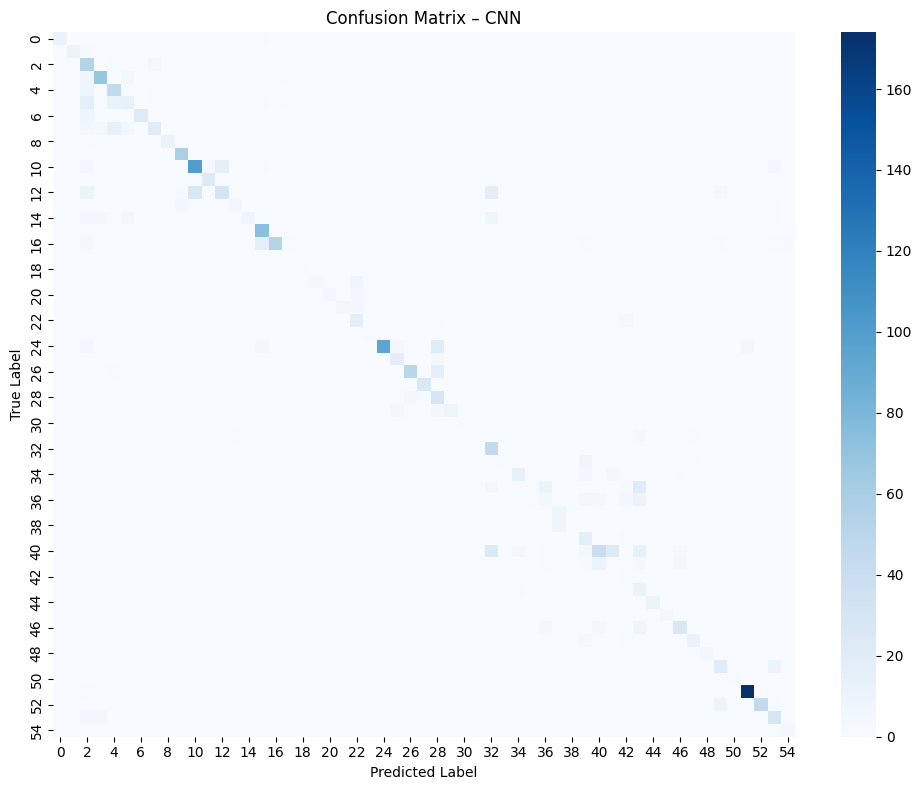

In [13]:
print("===== CNN TEST EVALUATION =====")

cnn_acc = accuracy_score(y_test_idx, cnn_preds)
cnn_prec = precision_score(y_test_idx, cnn_preds, average='macro', zero_division=0)
cnn_rec = recall_score(y_test_idx, cnn_preds, average='macro', zero_division=0)
cnn_f1 = f1_score(y_test_idx, cnn_preds, average='macro', zero_division=0)

print(f"Accuracy           : {cnn_acc:.4f}")
print(f"Precision (macro)  : {cnn_prec:.4f}")
print(f"Recall (macro)     : {cnn_rec:.4f}")
print(f"F1-score (macro)   : {cnn_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_idx, cnn_preds, zero_division=0))

cm_cnn = confusion_matrix(y_test_idx, cnn_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, cmap="Blues", fmt="d")
plt.title("Confusion Matrix – CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

def mcnemar_test(y_true, pred_a, pred_b, name_a="Model A", name_b="Model B"):
    # Build contingency table
    table = [[0, 0], [0, 0]]
    for yt, pa, pb in zip(y_true, pred_a, pred_b):
        if pa == yt and pb == yt:
            table[0][0] += 1
        elif pa == yt and pb != yt:
            table[0][1] += 1
        elif pa != yt and pb == yt:
            table[1][0] += 1
        else:
            table[1][1] += 1

    result = mcnemar(table, exact=True)

    print(f"\nMcNemar Test: {name_a} vs {name_b}")
    print("Contingency Table:", table)
    print("p-value:", result.pvalue)

    if result.pvalue < 0.05:
        print("✅ Statistically significant difference")
    else:
        print("❌ No statistically significant difference")




## Imports for classical Models

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
from statsmodels.stats.contingency_tables import mcnemar

## Classical model ()

In [15]:
# preprocessing data for classical model
def preprocess_for_classical_ml(X, target_size=32):
    X_small = []
    for img in X:
        img_resized = cv2.resize(
            img, (target_size, target_size),
            interpolation=cv2.INTER_LINEAR
        )
        X_small.append(img_resized.flatten())
    return np.array(X_small, dtype=np.float32)

X_train_flat = preprocess_for_classical_ml(X_train)
X_val_flat   = preprocess_for_classical_ml(X_val)
X_test_flat  = preprocess_for_classical_ml(X_test)

print("Flattened shape:", X_train_flat.shape)

from tensorflow.keras import layers, models

def build_feature_encoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu')
    ])
    return model

encoder = build_feature_encoder(X_train_flat.shape[1])



X_train_feat = encoder.predict(X_train_flat)
X_test_feat  = encoder.predict(X_test_flat)

print("Feature vector shape:", X_train_feat.shape)

svm = SVC(kernel='rbf', probability=True)

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}

svm_grid = GridSearchCV(
    svm, svm_params,
    cv=5, scoring='accuracy', n_jobs=-1
)

svm_grid.fit(X_train_feat, y_train_idx)
svm_best = svm_grid.best_estimator_

rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    rf, rf_params,
    cv=5, scoring='accuracy', n_jobs=-1
)

rf_grid.fit(X_train_feat, y_train_idx)
rf_best = rf_grid.best_estimator_


Flattened shape: (3419, 3072)
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Feature vector shape: (3419, 32)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


## Evaluating classical ml models



In [21]:
svm_preds = svm_best.predict(X_test_feat)
rf_preds  = rf_best.predict(X_test_feat)

def evaluate_model(name, y_true, y_pred):
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model("SVM", y_test_idx, svm_preds)
evaluate_model("Random Forest", y_test_idx, rf_preds)



===== SVM =====
Accuracy: 0.19558676028084251
Precision (macro): 0.21707165137348464
Recall (macro): 0.20508104531786225
F1-score (macro): 0.19771247786368937

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.29      0.17        14
           1       0.00      0.00      0.00        12
           2       0.08      0.07      0.07        60
           3       0.09      0.17      0.12        84
           4       0.08      0.10      0.09        58
           5       0.02      0.04      0.03        50
           6       0.04      0.07      0.05        30
           7       0.00      0.00      0.00        50
           8       0.75      0.43      0.55        14
          10       0.52      0.53      0.52        60
          11       0.44      0.37      0.40       130
          12       0.48      0.91      0.62        22
          13       0.00      0.00      0.00        92
          14       0.04      0.17      0.07        12
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

# mcnemar test

In [22]:
def mcnemar_test(y_true, pred1, pred2):
    table = [[0, 0], [0, 0]]
    for yt, p1, p2 in zip(y_true, pred1, pred2):
        if p1 == yt and p2 == yt:
            table[0][0] += 1
        elif p1 == yt and p2 != yt:
            table[0][1] += 1
        elif p1 != yt and p2 == yt:
            table[1][0] += 1
        else:
            table[1][1] += 1

    result = mcnemar(table, exact=True)
    print("McNemar p-value:", result.pvalue)

mcnemar_test(y_test_idx, svm_preds, rf_preds)


McNemar p-value: 0.001324281151414767


## Ploting confusion matrix

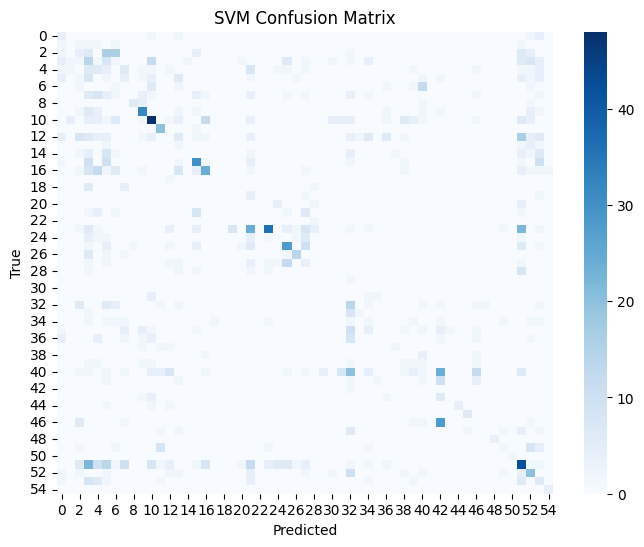

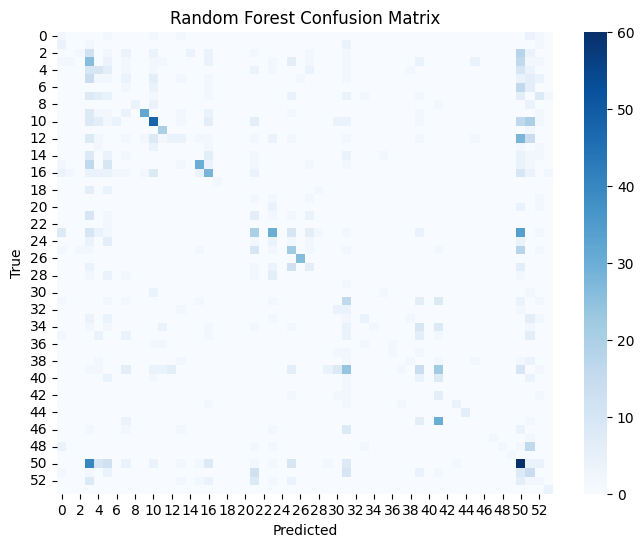

In [23]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap='Blues', fmt='d')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_test_idx, svm_preds, "SVM Confusion Matrix")
plot_cm(y_test_idx, rf_preds, "Random Forest Confusion Matrix")


## Comparative analysis

In [24]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["CNN", "SVM", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test_idx, cnn_preds),
        accuracy_score(y_test_idx, svm_preds),
        accuracy_score(y_test_idx, rf_preds)
    ],
    "Precision (macro)": [
        precision_score(y_test_idx, cnn_preds, average='macro', zero_division=0),
        precision_score(y_test_idx, svm_preds, average='macro', zero_division=0),
        precision_score(y_test_idx, rf_preds, average='macro', zero_division=0)
    ],
    "Recall (macro)": [
        recall_score(y_test_idx, cnn_preds, average='macro', zero_division=0),
        recall_score(y_test_idx, svm_preds, average='macro', zero_division=0),
        recall_score(y_test_idx, rf_preds, average='macro', zero_division=0)
    ],
    "F1-score (macro)": [
        f1_score(y_test_idx, cnn_preds, average='macro', zero_division=0),
        f1_score(y_test_idx, svm_preds, average='macro', zero_division=0),
        f1_score(y_test_idx, rf_preds, average='macro', zero_division=0)
    ]
})

results


,Model,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,CNN,0.676028,0.684884,0.667538,0.632289
1,SVM,0.195587,0.217072,0.205081,0.197712
2,Random Forest,0.218656,0.298590,0.225076,0.222815


# Saving Models

In [25]:
# CELL 10: save artifacts to Drive for report & reproducibility

OUT_DIR = "/content/drive/MyDrive/traffic_model_results"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Save CNN ---
cnn_model.save(os.path.join(OUT_DIR, "cnn_model.h5"))
np.save(os.path.join(OUT_DIR, "cnn_preds.npy"), cnn_preds)

# --- Save classical ML models ---
import joblib
joblib.dump(svm_best, os.path.join(OUT_DIR, "svm_model.joblib"))
joblib.dump(rf_best, os.path.join(OUT_DIR, "rf_model.joblib"))

np.save(os.path.join(OUT_DIR, "svm_preds.npy"), svm_preds)
np.save(os.path.join(OUT_DIR, "rf_preds.npy"), rf_preds)

# --- Save ground truth ---
np.save(os.path.join(OUT_DIR, "y_true.npy"), y_test_idx)

print("Saved all models and predictions to:", OUT_DIR)


Saved all models and predictions to: /content/drive/MyDrive/traffic_model_results
